# Init

In [35]:
%matplotlib inline

import csv
import datetime
import json
import math
import matplotlib
import time
import logging
import sys
import sqlite3
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer

In [2]:
import scipy.sparse

In [3]:
from scoring import main

In [4]:
from sklearn import random_projection

In [5]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [6]:
blogcatalog = loadmat('blogcatalog/blogcatalog.mat')

In [43]:
blog_labels = blogcatalog['group']

In [7]:
blog_A = blogcatalog['network']

In [8]:
blog_A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [9]:
N = blog_A.shape[0]

Obtain its transition matrix:

In [10]:
normalizer = spdiags(np.squeeze(1.0 / scipy.sparse.csc_matrix.sum(blog_A, axis=1) ), 0, N, N)

In [11]:
blog_trans = normalizer @ blog_A

# Degree Distribution

Write the graph to a file as adjacency list:

In [12]:
def sparse2graph(x):
    G = defaultdict(lambda: set())
    cx = x.tocoo()
    for i, j, v in zip(cx.row, cx.col, cx.data):
        G[i].add(j)
    
    lines = []
    for k, v in G.items():
        s = str(k) + ' ' + ' '.join(map(str, v))
        lines.append(s)
    return lines

In [13]:
G = nx.parse_adjlist(sparse2graph(blog_A))

Plot degree distribution:

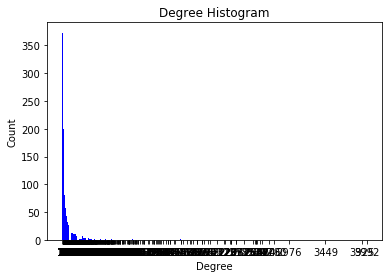

In [15]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

In [16]:
degreeCount

Counter({1: 270,
         2: 373,
         3: 352,
         4: 371,
         5: 368,
         6: 354,
         7: 287,
         8: 322,
         9: 310,
         10: 277,
         11: 228,
         12: 219,
         13: 225,
         14: 195,
         15: 199,
         16: 193,
         17: 145,
         18: 143,
         19: 137,
         20: 144,
         21: 131,
         22: 136,
         23: 115,
         24: 108,
         25: 114,
         26: 93,
         27: 121,
         28: 80,
         29: 93,
         30: 89,
         31: 87,
         32: 90,
         33: 94,
         34: 68,
         35: 75,
         36: 62,
         37: 59,
         38: 75,
         39: 71,
         40: 59,
         41: 58,
         42: 66,
         43: 60,
         44: 54,
         45: 61,
         46: 46,
         47: 71,
         48: 49,
         49: 43,
         50: 48,
         51: 54,
         52: 42,
         53: 43,
         54: 43,
         55: 41,
         56: 34,
         57: 41,
         58: 3

# Random Projection

Iterative computing:

In [17]:
def randne_projection(A, q=3, dim=128):
    transformer = random_projection.GaussianRandomProjection(n_components=dim, random_state=42)
    # Random projection for A
    cur_U = transformer.fit_transform(A)
    U_list = [cur_U]
    
    for i in range(2, q + 1):
        cur_U = A @ cur_U
        U_list.append(cur_U)
    return U_list

# Merge Embeddings

Merge embeddings (projections) from different powers of $A$ together:

In [18]:
def randne_merge(U_list, weights):
    U = np.zeros_like(U_list[0])
    for cur_U, weight in zip(U_list, weights):
        U += cur_U * weight
    return U

# Node Classification on Blogcatalog

Learn embeddings with the recommended configuration (trans matrix + recommended weights):

In [19]:
%%time
weights = list(map(lambda x: 0.01 * x, [1e2, 1e4, 1e5]))
U_list_fast = randne_projection(blog_trans, q=3, dim=128)
U_fast = randne_merge(U_list_fast, weights)

CPU times: user 238 ms, sys: 52.2 ms, total: 290 ms
Wall time: 290 ms


In [20]:
U_fast

array([[-0.48844904,  0.20275235, -0.4192839 , ..., -1.11367325,
        -4.4354135 , -1.8893595 ],
       [-1.52668501,  3.5871983 ,  0.85047499, ..., -1.22756421,
        -4.41966455, -1.55155192],
       [-0.44574345,  0.4061968 , -0.65713982, ..., -0.58740916,
        -4.95153347, -1.93410333],
       ...,
       [-1.41488359,  0.69459542, -1.08402925, ..., -1.40729178,
        -5.16958445, -2.06114091],
       [-2.5628838 ,  1.10293738, -2.63083881, ..., -0.99083508,
        -7.72526503, -1.04238015],
       [-3.67204472,  0.33042499,  4.1620681 , ..., -4.04393533,
        -9.70169837, -4.83837598]])

In [21]:
savemat('data/blog-trans-fast.mat', {'emb': U_fast})

Run classification:

In [24]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "data/blog-trans-fast.mat",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

[4862, 5968, 7609, 6098, 3391, 8523, 3041, 7315, 6068, 3326, 2142, 1608, 646, 3905, 6135, 3129, 9345, 5177, 9748, 130, 1934, 2885, 9875, 1170, 1880, 205, 7853, 575, 8308, 79, 5970, 8107, 6165, 4263, 545, 2884, 6934, 3398, 7024, 10081, 7219, 9379, 3767, 8634, 6305, 2348, 184, 6741, 9697, 7803, 2477, 3373, 9717, 8599, 8029, 4434, 1331, 9797, 848, 9600, 8554, 603, 10066, 5233, 6434, 3298, 9707, 753, 5842, 6472, 3342, 6199, 9412, 4385, 4544, 1103, 1735, 763, 7294, 6507, 1491, 258, 7843, 8266, 4207, 2166, 6496, 6953, 8500, 8544, 6280, 316, 9912, 6688, 7508, 5023, 3513, 6042, 4985, 8557]
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.3030674846625767, 'macro': 0.17843881642444398}
Average score: {'micro': 0.3030674846625767, 'macro': 0.17843881642444398}
-------------------
CPU times: user 2.69 s, sys: 4.49 s, total: 7.18 s
Wall time: 1.89 s


And run classification for DeepWalk:

In [70]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = main(
        ["--emb", "~/ws/deepwalk/example_graphs/blogcatalog.embeddings",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.34998850486627325, 'macro': 0.20068161161471323}
Average score: {'micro': 0.34998850486627325, 'macro': 0.20068161161471323}
-------------------
CPU times: user 3.15 s, sys: 5.17 s, total: 8.32 s
Wall time: 1.77 s


# Breakdown of Classification Perf

In [27]:
N = blog_A.shape[0]

In [45]:
mlb = MultiLabelBinarizer(range(blog_labels.shape[1]))

In [31]:
y_test, preds, indices_test = main(
        ["--emb", "data/blog-trans-fast.mat",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.29914661336203585, 'macro': 0.17326628732966903}
Average score: {'micro': 0.29914661336203585, 'macro': 0.17326628732966903}
-------------------


/home/hcchen/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
%time f1_score(mlb.fit_transform(y_test), mlb.fit_transform(preds), average='micro')

CPU times: user 47.9 ms, sys: 7.62 ms, total: 55.6 ms
Wall time: 54.7 ms


0.29914661336203585

And let's have a breakdown based on degree:

In [59]:
def filter_res_by_deg(y_test, preds, indices_test, min_deg, max_deg):
    filtered_y, filtered_preds = [], []
    for y, pred, index in zip(y_test, preds, indices_test):
        if min_deg <= G.degree[str(index)] <= max_deg:
            filtered_y.append(y)
            filtered_preds.append(pred)
    return f1_score(mlb.fit_transform(filtered_y), mlb.fit_transform(filtered_preds), average='micro')
    # return filtered_y, filtered_preds

In [95]:
randne_perf, dw_perf = [], []
for deg in range(1, 401, 10):
    randne_perf.append(filter_res_by_deg(y_test, preds, indices_test, deg, deg + 10))
    dw_perf.append(filter_res_by_deg(y_dw, preds_dw, indices_test_dw, deg, deg + 10))

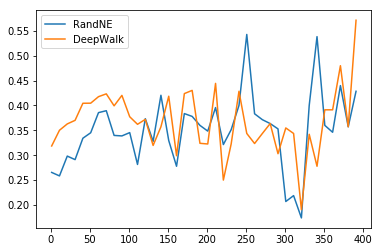

In [105]:
plt.plot(range(1, 401, 10), randne_perf, label='RandNE')
plt.plot(range(1, 401, 10), dw_perf, label='DeepWalk')
plt.legend()

In [106]:
randne_perf, dw_perf = [], []
for deg in range(1, 101, 10):
    randne_perf.append(filter_res_by_deg(y_test, preds, indices_test, deg, deg + 10))
    dw_perf.append(filter_res_by_deg(y_dw, preds_dw, indices_test_dw, deg, deg + 10))

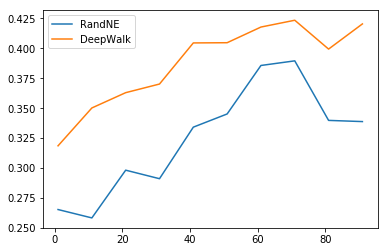

In [107]:
plt.plot(range(1, 101, 10), randne_perf, label='RandNE')
plt.plot(range(1, 101, 10), dw_perf, label='DeepWalk')
plt.legend()

In [62]:
filter_res_by_deg(y_test, preds, indices_test, 100, 1000)

0.34307992202729043

In [78]:
filter_res_by_deg(y_dw, preds_dw, indices_test_dw, 100, 1000)

0.36046511627906974

And for DeepWalk:

In [65]:
y_dw, preds_dw, indices_test_dw = main(
        ["--emb", "~/ws/deepwalk/example_graphs/blogcatalog.embeddings",
          "--network","blogcatalog/blogcatalog.mat",
          "--num-shuffles", "1"])

Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Shuffle #1:      {'micro': 0.357416781714987, 'macro': 0.21307696569035764}
Average score: {'micro': 0.357416781714987, 'macro': 0.21307696569035764}
-------------------


/home/hcchen/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
